# Seattle AirBnB Data Analysis

*This notebook captures the data analysis of AirBnB activity in Seattle using data released as a part of AirBnB Inside Initiative. The results of the analyis are also captured in a Medium blog here: https://medium.com/@hchawla94/seattle-airbnb-data-analysis-a47920dfc5b5*

### Business Understanding

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, the dataset used here describes the listing activity of homestays in Seattle, WA.

As part of this project, I would be investigating the below questions in relation to the data:

- **Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?**
- **Q2: Which are the most popular neigborhoods? Can these neighborhoods be described using the data available?**
- **Q3: Can we use listing details to predict listing price? If yes, which information is the most significant predictor?**


### Data Understanding

The following Airbnb activity is included in the Seattle dataset used here:
 * Listings, including full descriptions and average review score 
 * Reviews, including unique id for each reviewer and detailed comments 
 * Calendar, including listing id and the price and availability for that day

In [1]:
# Import libraries

import nltk
nltk.download('punkt')
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import re

from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor  

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hardik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load data
seattle_calendar = pd.read_csv('data/calendar.csv')
seattle_listing = pd.read_csv('data/listings.csv')
seattle_review = pd.read_csv('data/reviews.csv')

# Check data shapes and counts
print("#Rows, #columns in Seattle Listing: \t", seattle_listing.shape)
print("#Rows, #columns in Seattle Calendar: \t", seattle_calendar.shape)
print("#Rows, #columns in Seattle Review: \t", seattle_review.shape)

print("#Unique Listing IDs in Seattle Listing: \t", seattle_listing.id.nunique())
print("#Unique Listing IDs in Seattle Calendar: \t", seattle_calendar.listing_id.nunique())
print("#Unique Listing IDs in Seattle Review: \t", seattle_review.listing_id.nunique())

print("\nCheck overlap of Listing IDs in Listing and Calendar df: \n", seattle_listing['id'].isin(seattle_calendar['listing_id']).value_counts())
print("Check overlap of Listing IDs in Listing and Review df: \n", seattle_listing['id'].isin(seattle_review['listing_id']).value_counts())

#Rows, #columns in Seattle Listing: 	 (3818, 92)
#Rows, #columns in Seattle Calendar: 	 (1393570, 4)
#Rows, #columns in Seattle Review: 	 (84849, 6)
#Unique Listing IDs in Seattle Listing: 	 3818
#Unique Listing IDs in Seattle Calendar: 	 3818
#Unique Listing IDs in Seattle Review: 	 3191

Check overlap of Listing IDs in Listing and Calendar df: 
 True    3818
Name: id, dtype: int64
Check overlap of Listing IDs in Listing and Review df: 
 True     3191
False     627
Name: id, dtype: int64


In [3]:
# Review of Seattle listing data
seattle_listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [4]:
# Check some of the columns which seem to capture constant values
print(seattle_listing.last_scraped.value_counts(),
      seattle_listing.calendar_last_scraped.value_counts(),
      seattle_listing.experiences_offered.value_counts())

2016-01-04    3818
Name: last_scraped, dtype: int64 2016-01-04    3818
Name: calendar_last_scraped, dtype: int64 none    3818
Name: experiences_offered, dtype: int64


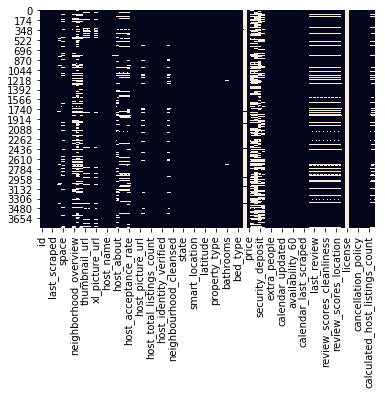

In [5]:
# Check for missing values
sns.heatmap(seattle_listing.isnull(), cbar=False)

**Data Note** (Listing Data): 
- The data captures information for 3818 listings; however, reviews are captured only for 3191 listings
- Price column needs to be cleaned and converted to the correct format
- Few columns have a lot of missing values and may need to be dropped from the analysis

In [6]:
# Review of Seattle Calendar data
seattle_calendar.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [7]:
# Convert date to datetime format and check date range
seattle_calendar['date'] = pd.to_datetime(seattle_calendar['date'])
print(seattle_calendar['date'].min())
print(seattle_calendar['date'].max())

2016-01-04 00:00:00
2017-01-02 00:00:00


In [8]:
# There are NaNs only for the records for which available != t in calendar data
((seattle_calendar['available'] == 't') & (seattle_calendar['price'].isnull())).sum()

0

In [9]:
# Price seems to be as an object presently and hence needs to be converted
seattle_calendar[['price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 1 columns):
price    934542 non-null object
dtypes: object(1)
memory usage: 10.6+ MB


**Data Note** (Calendar Data): 
- Captures data from 2016-01-04 to 2017-01-02
- In case a listing is not available the price captured against it is NaN
- Date is in string format and needs to be converted for analysis

In [10]:
# Review of Seattle Review data
seattle_review.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [11]:
# Data count and type QC
seattle_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [12]:
# Data QC
seattle_review.date.nunique()/365

5.287671232876712

**Data Note** (Review Data): 
- Captures data for approximately 5 years
- Comments column has a few NaNs
- Date column would need to be converted to the correct format

### Data Preparation and Cleaning

In [13]:
# Convert price to numeric by cleaning $ sign and changing data type
def cleaned_prices(col,data):
    ''' Cleans the corresponding column of the dataset by converting price to numeric
    Input : column, dataset
    Ouput : None '''
    data[col] = data[col].str.replace('$','').str.replace(',','')
    data[col] = pd.to_numeric(data[col]);

In [14]:
# Clean price column
cleaned_prices('price', seattle_calendar)
cleaned_prices('price', seattle_listing)

In [15]:
# Convert date to datetime format 
seattle_calendar['date'] = pd.to_datetime(seattle_calendar['date'])
seattle_review['date'] = pd.to_datetime(seattle_review['date'])
seattle_listing['host_since'] = pd.to_datetime(seattle_listing['host_since'])
seattle_listing['first_review'] = pd.to_datetime(seattle_listing['first_review'])
seattle_listing['last_review'] = pd.to_datetime(seattle_listing['last_review'])
seattle_listing['last_scraped'] = pd.to_datetime(seattle_listing['last_review'])

In [16]:
# Add year and month to the calendar data
seattle_calendar['year'] = (seattle_calendar['date'].dt.year)
seattle_calendar['month'] = (seattle_calendar['date'].dt.month)
seattle_calendar['MonthYear'] = pd.to_datetime(seattle_calendar.year.astype(str) + seattle_calendar.month.astype(str), format='%Y%m')
seattle_calendar['MonthYear'] = seattle_calendar['MonthYear'].dt.to_period('M')

In [17]:
# Add year and month to the review data
seattle_review['year'] = (seattle_review['date'].dt.year).astype('str')
seattle_review['month'] = (seattle_review['date'].dt.month).astype('str')
seattle_review['MonthYear'] = seattle_review[['year', 'month']].apply(lambda x: '_'.join(x), axis=1)
seattle_review['MonthYear'] = pd.to_datetime(seattle_review.year.astype(str) + seattle_review.month.astype(str), format='%Y%m')
seattle_review['MonthYear'] = seattle_review['MonthYear'].dt.to_period('M')

In [18]:
# Drop cols with large number of NaNs in listing data or with constant values or cols which won't be needed presumably
drop_cols = ['experiences_offered','listing_url''calendar_last_scraped','scrape_id','requires_license',
             'smart_location','host_id','host_name','host_url','square_feet', 'license','state','city',
             'market','country_code','country']
listing_cols = [c for c in seattle_listing.columns if c not in drop_cols]

In [19]:
# Keep only selected columns in litsing data
seattle_listing = seattle_listing[listing_cols]

### Data Analysis and Modelling

**Q1: What are the busiest times of the year to visit Seattle? By how much do prices spike?**

Text(0.5, 0, 'Month Year')

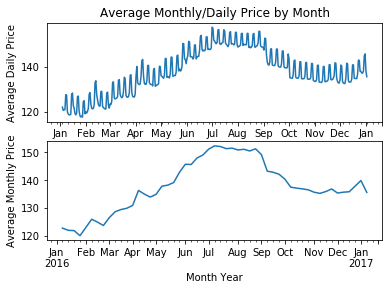

In [20]:
# Analyze price trends 
avg_price_df = seattle_calendar.groupby(['date'])['price'].mean()
plt.subplot(211)
avg_price_df.resample('D').mean().plot()
plt.title('Average Monthly/Daily Price by Month')
plt.ylabel ('Average Daily Price')
plt.subplot(212)
avg_price_df.resample('W').mean().plot()
plt.ylabel ('Average Monthly Price')
plt.xlabel ('Month Year')


In [21]:
# Check average monthly price to compare spikes by month
seattle_calendar.groupby(['MonthYear'])['price'].mean()

MonthYear
2016-01    121.568409
2016-02    124.293927
2016-03    128.644488
2016-04    135.097005
2016-05    139.538183
2016-06    147.473137
2016-07    152.094150
2016-08    150.656594
2016-09    143.255949
2016-10    137.031939
2016-11    135.688738
2016-12    137.251835
2017-01    136.882590
Freq: M, Name: price, dtype: float64

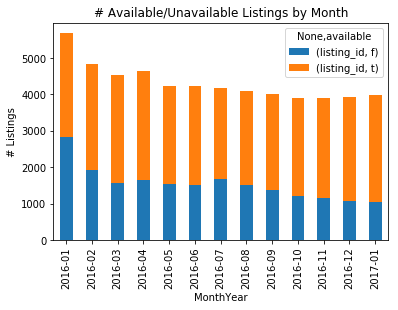

In [22]:
# Analyze availability trends 
available_df = seattle_calendar.groupby(['MonthYear','available'], as_index=False).agg({"listing_id": "nunique"})
available_df.pivot(columns='available',index='MonthYear').plot(kind='bar',stacked=True,legend=True)
plt.ylabel ('# Listings')
plt.title  ('# Available/Unavailable Listings by Month');

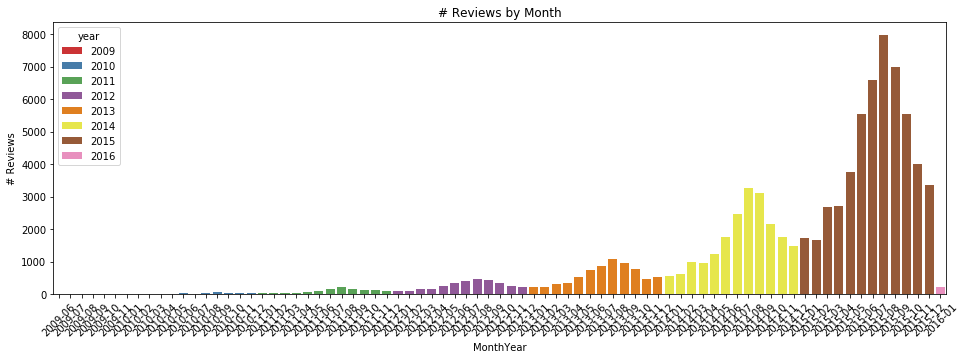

In [23]:
# Analyze review trends 
review_count_df = seattle_review.groupby(['MonthYear','year'], as_index=False).agg({"id": "nunique"})
plt.figure(figsize=(16, 5))
ax = sns.barplot(review_count_df.MonthYear, review_count_df.id,
            hue=review_count_df.year, dodge=False, palette='Set1')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.ylabel ('# Reviews')
plt.title  ('# Reviews by Month');

**Ans. 1** 
- The period Jul-Aug seems to be the busiest period for the following reasons
    - The average monthly prices are the highest during the period
    - Least number of rooms are available during the period
    - Most of the reviews are recorded during this period likely after completion of stay
- The prices seem to spike by almost 1.25x between Jan (start of the year) to Jul (the peak period)

**Q2: Which are the most popular neigborhoods? Can their vibe be described using listing descriptions?**

In [24]:
# Create dataframe
seattle_neighbour = seattle_listing[['neighbourhood','neighborhood_overview']]

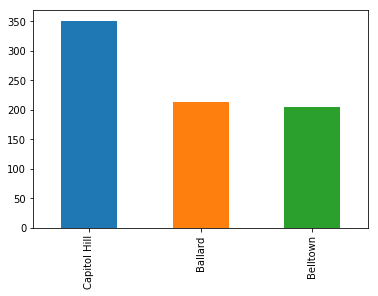

In [25]:
# Check for most requested neighborhoods
seattle_neighbour['neighbourhood'].value_counts().nlargest(3).plot.bar()

In [26]:
# Select and analyze data for only the top 3 neighborhoods 
subset = ['Capitol Hill','Ballard','Belltown']
seattle_neighbour = seattle_neighbour[seattle_neighbour.neighbourhood.isin(subset)]
seattle_neighbour.dropna(inplace=True)

In [27]:
# Function for a quick look at term document matrix
def quick_tfidf(df):
    ''' Returns the top features of the term document matrix
    Input : dataset
    Ouput : None '''
    vect = TfidfVectorizer(tokenizer=word_tokenize,ngram_range=(1,2), binary=True, max_features=60, stop_words='english')
    TFIDF=vect.fit_transform(df.neighborhood_overview)
    print(vect.get_feature_names())

In [28]:
# Check for 'Capitol Hill'
quick_tfidf(seattle_neighbour[seattle_neighbour.neighbourhood.isin(['Capitol Hill'])])

['!', "'s", '(', ')', ',', ', bars', ', restaurants', '.', 'apartment', 'art', 'away', 'away .', 'bars', 'bars ,', 'best', 'blocks', 'broadway', 'bus', 'capitol', 'capitol hill', 'center', 'central', 'city', 'close', 'coffee', 'coffee shops', 'distance', 'downtown', 'downtown seattle', 'easy', 'great', 'grocery', 'hill', 'just', 'located', 'market', 'minute', 'minute walk', 'neighborhood', 'neighborhoods', 'nightlife', 'park', 'parks', 'pike', 'place', 'restaurants', 'restaurants ,', 'right', 'seattle', "seattle 's", 'seattle .', 'shops', 'shops ,', 'street', 'vibrant', 'volunteer', 'volunteer park', 'walk', 'walking', 'walking distance']


In [29]:
# Check for 'Ballard'
quick_tfidf(seattle_neighbour[seattle_neighbour.neighbourhood.isin(['Ballard'])])

['!', "'s", '(', ')', ',', ', restaurants', '.', ':', 'amazing', 'area', 'away', 'away .', 'ballard', 'ballard ,', 'ballard locks', 'bars', 'bars ,', 'beach', 'best', 'blocks', 'bus', 'city', 'close', 'coffee', 'distance', 'downtown', 'downtown seattle', 'easy', 'farmers', 'farmers market', 'gardens', 'gardens beach', 'golden', 'golden gardens', 'great', 'home', 'just', 'located', 'locks', 'market', 'minute', 'minutes', 'music', 'neighborhood', 'neighborhoods', 'park', 'parks', 'quiet', 'restaurants', 'restaurants ,', 'seattle', 'seattle .', 'shopping', 'shops', 'shops ,', 'street', 'sunday', 'walk', 'walking', 'walking distance']


In [30]:
# Check for 'Belltown'
quick_tfidf(seattle_neighbour[seattle_neighbour.neighbourhood.isin(['Belltown'])])

['!', "'s", '(', ')', ',', ', seattle', '.', ':', 'aquarium', 'area', 'art', 'art museum', 'attractions', 'away', 'bars', 'belltown', 'blocks', 'center', 'center ,', 'distance', 'downtown', 'downtown seattle', 'experience', 'great', 'heart', 'heart downtown', 'just', 'located', 'market', 'market ,', 'museum', 'music', 'music project', 'needle', 'needle ,', 'neighborhood', 'pacific', 'park', 'pike', 'pike place', 'place', 'place market', 'project', 'restaurants', 'restaurants ,', 'science', 'science center', 'score', 'seattle', "seattle 's", 'seattle center', 'shopping', 'space', 'space needle', 'street', 'walk', 'walk score', 'walking', 'walking distance', 'waterfront']


**Ans. 2** 
- Capitol Hill, Ballard, Belltown seem to be the most requested neighborhood per analysis of the listings data
- Following is a high-level description of their vibe per a quick analysis:
    - Capitol Hill: Capitol Hill is close to Pike Palace market. It seems to have an active nightlife as well as coffee shops
    - Ballard: Ballard is close to farmers market and golden gardens. It seems to have a lot of coffee shops and it is near to the beach as well
    - Belltown: Belltown listing are around the area which has popular attractions such as art museum, space needle and pike palace market. It is a good spot for shopping and exploration 

**Q3: Can we use listing details to predict listing price? If yes, which information is the most significant predictor?**

In [31]:
# Check data
seattle_listing.head(2)

,id,listing_url,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2016-01-02,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2015-12-29,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,WASHINGTON,f,strict,t,t,6,1.48


In [32]:
# Get all numeric columns from seattle, check for NaNs
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = seattle_listing.select_dtypes(include=numerics).columns
seattle_listing[num_cols].isna().sum()

id                                  0
host_listings_count                 2
host_total_listings_count           2
latitude                            0
longitude                           0
accommodates                        0
bathrooms                          16
bedrooms                            6
beds                                1
price                               0
guests_included                     0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
review_scores_rating              647
review_scores_accuracy            658
review_scores_cleanliness         653
review_scores_checkin             658
review_scores_communication       651
review_scores_location            655
review_scores_value               656
calculated_host_listings_count      0
reviews_per_

In [33]:
# Fill numeric NaNs with mean
seattle_listing[num_cols] = seattle_listing[num_cols].fillna(seattle_listing[num_cols].mean())

In [34]:
# Check categorical columns
other_cols= seattle_listing.select_dtypes(include=['object']).columns

In [35]:
# Drop additional columns which seem to be misc.
# Also, weekly price and monthly price would be highly correlated with price; hence, drop those
drop_cols2 = ['listing_url', 'name', 'summary', 'space', 'description','neighborhood_overview', 'notes', 'transit', 
              'thumbnail_url','medium_url', 'picture_url', 'xl_picture_url', 'host_about','host_thumbnail_url', 
              'host_picture_url','jurisdiction_names','weekly_price','monthly_price']
# Reduced seattle listing df
listing_cols2 = [c for c in seattle_listing.columns if c not in drop_cols2]
seattle_listing = seattle_listing[listing_cols2]

In [36]:
# Clean prices, not cleaned previously to avoid incorrect imputation
cleaned_prices('security_deposit', seattle_listing)
cleaned_prices('cleaning_fee', seattle_listing)
cleaned_prices('extra_people', seattle_listing)

In [37]:
# Encode boolean true/false values
bool_encode = {
    'host_is_superhost' : {'f':0, 't':1},
    'host_identity_verified': {'f':0, 't':1},
    'is_location_exact': {'f':0, 't':1},
    'instant_bookable': {'f':0, 't':1},
    'require_guest_profile_picture': {'f':0, 't':1},
    'require_guest_phone_verification': {'f':0, 't':1},
    'host_has_profile_pic': {'f':0, 't':1}
}

seattle_listing.replace(bool_encode, inplace=True)

In [38]:
# Drop Nans from boolean encoded columns
bool_cols = ['host_is_superhost','host_identity_verified','is_location_exact','instant_bookable',
             'require_guest_profile_picture','require_guest_phone_verification','host_has_profile_pic']

seattle_listing = seattle_listing.dropna(subset=['host_is_superhost'])
seattle_listing = seattle_listing.dropna(subset=['property_type'])

# Convert to int data type
seattle_listing[bool_cols] = seattle_listing[bool_cols].astype(int)

In [39]:
# new feature: to check for how long host has been active 
seattle_listing.last_scraped_max = seattle_listing.last_scraped.max()
seattle_listing.host_since_days = (seattle_listing.last_scraped_max - seattle_listing.host_since).dt.days

In [40]:
# new feature: to check for total review duration first review to last
seattle_listing.review_duration = (seattle_listing.last_review - seattle_listing.first_review).dt.days

In [41]:
# neighbourhood_group_cleansed seems to be a comprehensive representation of neighbourhood values
# new feature created host neighborhood same as property neighborhood
seattle_listing['host_in_same_neighbourhood'] = (
    seattle_listing['host_neighbourhood'] == seattle_listing['neighbourhood']).astype(int)

In [42]:
# Drop additonal features
drop_cols3 = ['neighbourhood_cleansed','host_since', 'last_scraped','zipcode','latitude','longitude','host_location','street',
              'neighbourhood','host_neighbourhood']

# Reduced seattle listing df
listing_cols3 = [c for c in seattle_listing.columns if c not in drop_cols3]
seattle_listing = seattle_listing[listing_cols3]

In [43]:
# Split out various values in host verfication as separate features
# Get list of all verification methods
methods_list = list()
for methods in seattle_listing['host_verifications'].unique():
    methods_list += re.findall(r"\'(\w+)\'", methods)
    methods_list = list(set(methods_list))

# Create new columns for each method and initialize with zero
for method in methods_list:
    seattle_listing.loc[:, method] = 0.0

# Checking original column and decode the result into above created columns
for index, value in seattle_listing['host_verifications'].iteritems():
    methods = re.findall(r"\'(\w+)\'", value)
    seattle_listing.loc[index, methods] = 1.0

seattle_listing.drop(['host_verifications'], axis=1, inplace=True)

In [44]:
# Split out various values in amenities as separate features
# Get list of all verification methods
amenities_list = list()
for amenities in seattle_listing['amenities'].unique():
    amenities_list += re.findall(r"\{([^\{\}\'\"\,]+)\,", amenities)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\}", amenities)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\,", amenities)
    amenities_list += re.findall(r"\"([^\{\}\'\"\,]+)\"", amenities)
    amenities_list = list(set(amenities_list))

# Create new columns for each amenity and initialize with zero.
for amenity in amenities_list:
    seattle_listing.loc[:, amenity] = 0.0

# Checking original column and decode the result into above created columns.
for index, value in seattle_listing['amenities'].iteritems():
    amenities_list = re.findall(r"\{([^\{\}\'\"\,]+)\,", value)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\}", value)
    amenities_list += re.findall(r"\,([^\{\}\'\"\,]+)\,", value)
    amenities_list += re.findall(r"\"([^\{\}\'\"\,]+)\"", value)
    seattle_listing.loc[index, amenities_list] = 1.0

seattle_listing.drop(['amenities'], axis=1, inplace=True)

In [45]:
# Fill cleaning fee and security deposit NaNs with 0
seattle_listing[['security_deposit','cleaning_fee']] = seattle_listing[['security_deposit','cleaning_fee']].fillna(0)


In [46]:
# Convert host response and acceptance rates into 0-1 scale
seattle_listing['host_response_rate'] = pd.to_numeric(seattle_listing['host_response_rate'].apply(lambda x: str(x)
                                                                                              .replace('%', '')
                                                                                              .replace('N/A', '')),
                                                    errors='coerce')/100

seattle_listing['host_acceptance_rate'] = pd.to_numeric(seattle_listing['host_acceptance_rate'].apply(lambda x: str(x)
                                                                                              .replace('%', '')
                                                                                              .replace('N/A', '')),
                                                    errors='coerce')/100

In [47]:
# Function to convert response time column to numeric
def response_time_map(x):
    ''' Maps response time column values to corresponding numeric values
    Input : column
    Ouput : column'''
    
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    elif x == np.nan:
        np.nan
    else:
        x='96'
        
    return x

In [48]:
# Convert response time column to numeric
seattle_listing['host_response_time'] = seattle_listing['host_response_time'].apply(response_time_map).astype(int)

### Data Modeling

In [49]:
# Features for price prediction would likely depend on host and facility related features; hence, dropping other features
drop_cols4 = ['calendar_last_scraped','first_review','has_availability','last_review','calendar_updated']

# Reduced seattle listing df
listing_cols4 = [c for c in seattle_listing.columns if c not in drop_cols4]
seattle_listing = seattle_listing[listing_cols4]

In [50]:
# Create df copy
price_pred_df = seattle_listing.copy(deep=True)

In [51]:
# One Hot Encode Categorical columns
price_pred_df = pd.get_dummies(price_pred_df, columns=['neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'cancellation_policy'], drop_first=True)

# Fill Na with 0
price_pred_df.fillna(0,inplace=True)

In [52]:
# Intialize X and y for model
X = price_pred_df.drop(['price','id'], axis=1)
y = price_pred_df['price']

In [53]:
# Function to calculate VIF
def calculate_vif_(X, thresh=100):
    ''' Calculates VIF - to ascertain multicolinearity and drops column below the given threshold
    Input : dataset
    Ouput : dataset '''
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True
    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [54]:
# Check for multicolinearity using VIF and drop columns
X = calculate_vif_(X, thresh=50)

dropping 'host_listings_count' at index: 4
dropping 'review_scores_communication' at index: 27
dropping 'review_scores_rating' at index: 23
dropping 'review_scores_checkin' at index: 25
dropping 'review_scores_accuracy' at index: 23
dropping 'host_has_profile_pic' at index: 5
dropping 'review_scores_location' at index: 23
dropping 'review_scores_value' at index: 23
dropping 'availability_60' at index: 18
dropping 'review_scores_cleanliness' at index: 21
dropping 'phone' at index: 35
dropping 'bed_type_Real Bed' at index: 117
dropping 'host_response_rate' at index: 1
Remaining variables:
Index(['host_response_time', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_identity_verified',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       ...
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Yurt', 'room_type_Private room', 'room_type_Shared room',
       'bed_type_Couch', 'bed_type_Futon'

In [55]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [56]:
# Instantiate a pipeline for Gradient Boost Regressor
pipe = Pipeline([('scl', StandardScaler()),
                     ('est', GradientBoostingRegressor(random_state=42))])

In [57]:
# Set hyperparameters for GridSearch
param_grid = {
    'est__learning_rate': [0.1, 0.05],  # default: 0.1
    'est__max_depth': [3, 4, 5],        # default: 3
    'est__min_samples_leaf': [1, 3, 5]  # default: 1
}

# GridSearchCV
gs = GridSearchCV(estimator=pipe,
                      param_grid=param_grid, scoring='r2', cv=3, verbose=1)

# Fit data to model
gs = gs.fit(X_train, y_train)
print('Best Model: %s' % gs.best_estimator_.named_steps['est'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   46.6s finished


Best Model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


### Evaluation

In [58]:
# Predict on X_train and X_test using Gradient Boosting model
y_pred_train = gs.best_estimator_.predict(X_train)
y_pred_test = gs.best_estimator_.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
print('R2 score (Gradient Boosting Regressor, Train Data):{}'.format(r2_score_train))
print('R2 score (Gradient Boosting Regressor, Test Data):{}'.format(r2_score_test))

R2 score (Gradient Boosting Regressor, Train Data):0.7565470079058582
R2 score (Gradient Boosting Regressor, Test Data):0.6687977692360059


[Text(0, 0.5, 'Predicted Price'), Text(0.5, 0, 'Actual Price')]

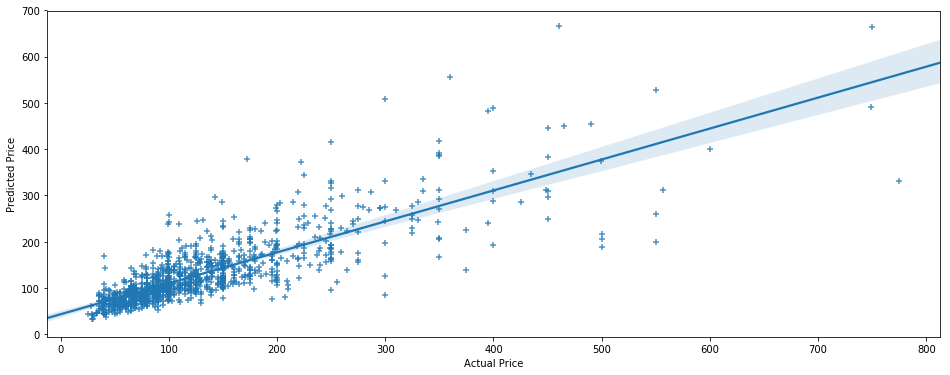

In [59]:
plt.figure(figsize=(16, 6))
ax = sns.regplot(x=y_test, y=y_pred_test, marker="+")
ax.set(xlabel='Actual Price', ylabel='Predicted Price')

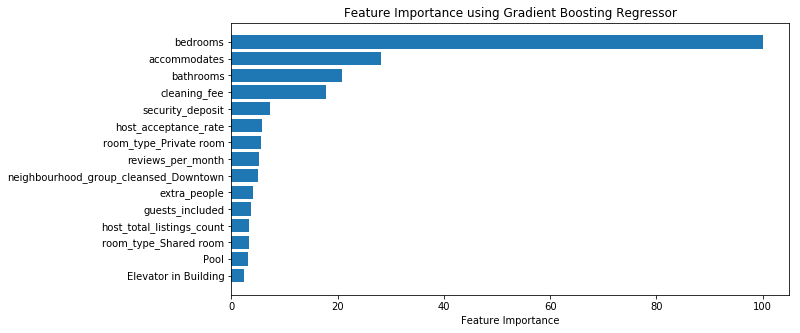

In [60]:
# Using the best score model, i.e. Gradient Boosting
# Plot feature importance in sort order
# Extract estimator from pipe
estimator = gs.best_estimator_.named_steps['est']
feature_importance = estimator.feature_importances_
feature_importance = 100.0 * \
    (feature_importance / feature_importance.max())  # max-scaling
sorted_idx = np.argsort(feature_importance)
# Extracting top 15 features
top_feature_names = X.columns.values[sorted_idx][-15:]
top_feature_importance = feature_importance[sorted_idx][-15:]

# Plot
fig = plt.figure(figsize=(10,5))
pos = np.arange(len(top_feature_names))
plt.barh(pos, top_feature_importance, align='center')
plt.yticks(pos, top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance using Gradient Boosting Regressor')
plt.show()


In [61]:
# Check for correlation with price column to validate findings 
corr = price_pred_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included']].corr()

corr.style.background_gradient(cmap='coolwarm')

,accommodates,bathrooms,bedrooms,beds,price,guests_included
accommodates,1,0.537913,0.7706,0.861073,0.652665,0.532704
bathrooms,0.537913,1,0.61073,0.532179,0.516296,0.304461
bedrooms,0.7706,0.61073,1,0.752963,0.628014,0.456852
beds,0.861073,0.532179,0.752963,1,0.589704,0.460396
price,0.652665,0.516296,0.628014,0.589704,1,0.39315
guests_included,0.532704,0.304461,0.456852,0.460396,0.39315,1


**Ans. 3** 
- The listing price can be predicted using the features in the listing dataset. A Gradient Boosting Regressor model was tuned to get an R2 score of 0.668 on 70:30 train-test split
- Per the model, following seem to be the most important features related to the price prediction:
    - bedrooms: per the # bedrooms the price is highly corelated
    - bathrooms: price also depends on # bathrooms
    - accomodates: price is also related with the number of people an house accomodates
    - Price is effected by the amenities provided at the facility - pool, elevator etc.
    - Room Type and Neighborhood are also important features when it comes to determining price
    